In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

### Load and inspect data

In [2]:
ls ../data/

E2_OCV_P25.mat


In [3]:
data = scipy.io.loadmat('../data/E2_OCV_P25.mat', simplify_cells=True)

In [4]:
fields = list(data['OCVData']['script1'].keys())

In [5]:
fields

['time', 'step', 'current', 'voltage', 'chgAh', 'disAh']

In [6]:
def plot_data(script):

    fig = plt.figure(figsize=(12,8))
    fig.suptitle(script, fontsize=16)

    for i,j in zip(range(1,6), fields[1:]):
        plt.subplot(3, 2, i)
        plt.plot(data['OCVData'][script]['time'],data['OCVData'][script][j])
        plt.xlabel('time (s)',fontsize=12)
        plt.ylabel(j, fontsize=12)
        plt.grid()
        
    plt.tight_layout()

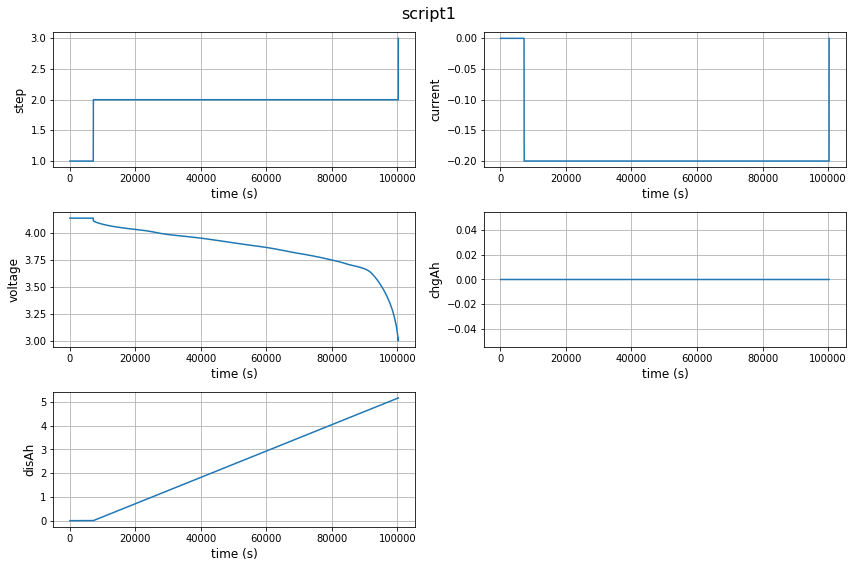

In [7]:
plot_data('script1')

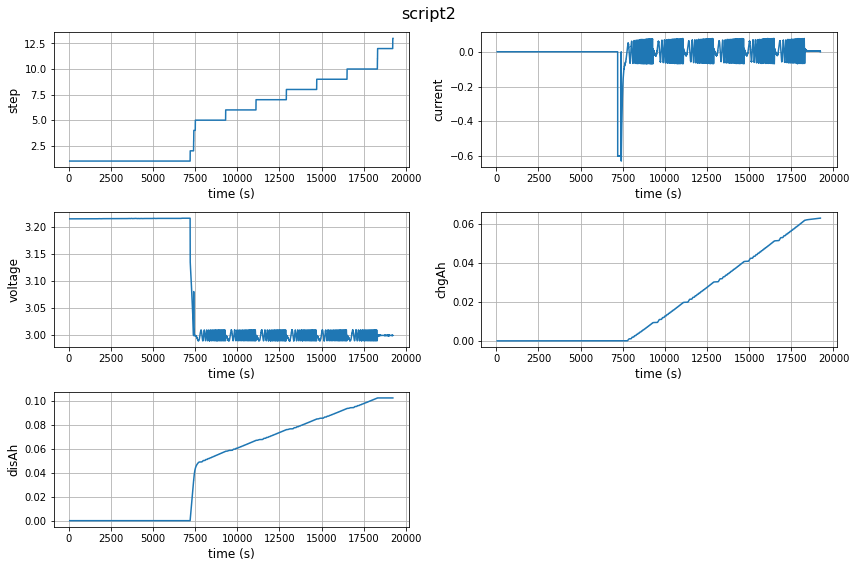

In [8]:
plot_data('script2')

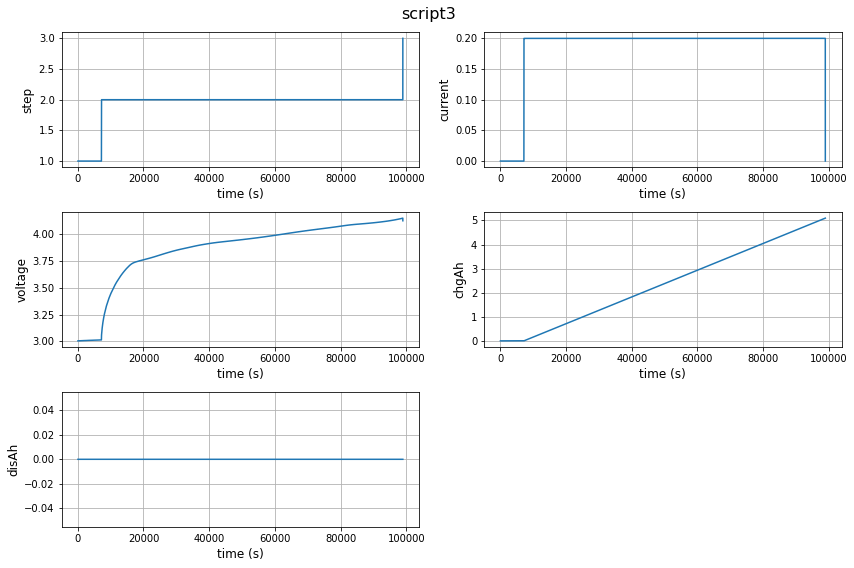

In [9]:
plot_data('script3')

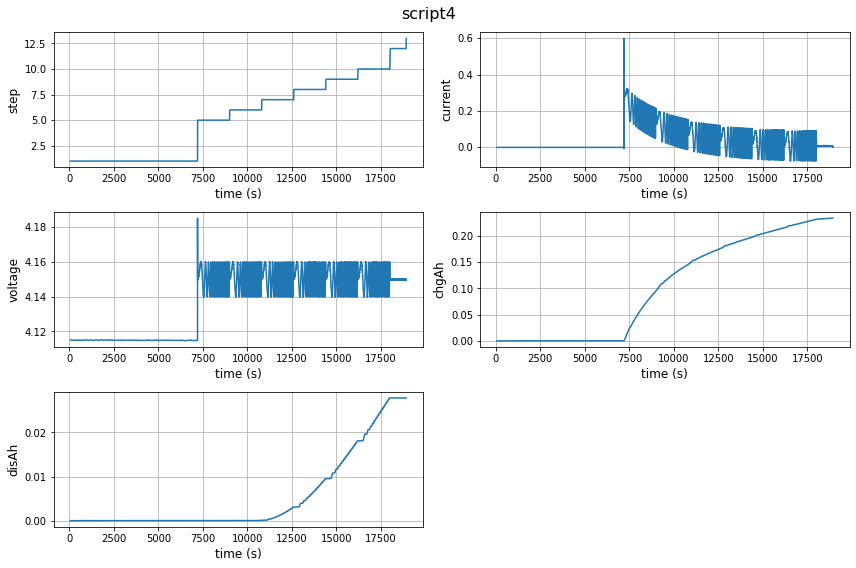

In [10]:
plot_data('script4')

### Find Coulombic Efficiency

In [11]:
scripts = ['script1','script2','script3','script4']

In [12]:
total_discharge = 0
total_charge = 0

for script in scripts: 
    
    total_discharge += data['OCVData'][script]['disAh'][-1]
    total_charge += data['OCVData'][script]['chgAh'][-1]

In [13]:
eta_25 = total_discharge / total_charge

In [14]:
eta_25

0.9833966792302935

### Find Total Capacity

In [15]:
# There really shouldn't be any charging done in Script 1, but 
# this is rigorously defined here to include

Q_25 = data['OCVData']['script1']['disAh'][-1] \
     + data['OCVData']['script2']['disAh'][-1] \
     - eta_25*data['OCVData']['script1']['chgAh'][-1] \
     - eta_25*data['OCVData']['script2']['chgAh'][-1]

In [16]:
Q_25

5.21270581784224

### Finding approximate OCV relationship at this temperature

First, we want to remove the bias in voltage caused by IR drop from both discharge and charge curves.

In [17]:
# Implement this one in Pandas
df_1 = pd.DataFrame(data['OCVData']['script1'])

In [18]:
df_1.head(2)

,time,step,current,voltage,chgAh,disAh
0,60.014559,1,0.0,4.138844,0,0.0
1,120.029137,1,0.0,4.138844,0,0.0


In [19]:
# Beginning of discharge
IR1Da = df_1[df_1['step'] == 1].tail(1).voltage.values[0] \
        - df_1[df_1['step'] == 2].head(1).voltage.values[0]
print(IR1Da)

0.02411365509033203


In [20]:
# End of discharge
IR2Da = df_1[df_1['step'] == 3].head(1).voltage.values[0] \
        - df_1[df_1['step'] == 2].tail(1).voltage.values[0]
print(IR2Da)

0.02492833137512207


In [21]:
# Implement this one in Numpy
IndC = np.where(data['OCVData']['script3']['step'] == 2)[0]

In [22]:
# Beginning of charge
IR1Ca = data['OCVData']['script3']['voltage'][IndC[0]] \
        - data['OCVData']['script3']['voltage'][IndC[0]-1]
print(IR1Ca)

0.03209733963012695


In [23]:
# End of charge
IR2Ca = data['OCVData']['script3']['voltage'][IndC[-1]] \
        - data['OCVData']['script3']['voltage'][IndC[-1]+1]
print(IR2Ca)

0.023624897003173828


In [24]:
# These are just some sanity checks to keep these correction factors 
# from getting too large in case of data issues 
IR1D = min(IR1Da,2*IR2Ca)
IR2D = min(IR2Da,2*IR1Ca)
IR1C = min(IR1Ca,2*IR2Da)
IR2C = min(IR2Ca,2*IR1Da)

In [25]:
# Discharge voltage & SOC curves
IndD = np.where(data['OCVData']['script1']['step'] == 2)[0]
blend = np.linspace(0,1,len(IndD))
IRblend = IR1D + (IR2D-IR1D)*blend
disV = data['OCVData']['script1']['voltage'][IndD] + IRblend

# Z = State of Charge
disZ = 1 - data['OCVData']['script1']['disAh'][IndD]/Q_25
disZ = disZ + (1 - disZ[0])

In [26]:
assert disZ.shape == disV.shape

In [27]:
# Charge voltage & SOC curves
blend = np.linspace(0,1,len(IndC))
IRblend = IR1C + (IR2C-IR1C)*blend
chgV = data['OCVData']['script3']['voltage'][IndC] - IRblend
chgZ = data['OCVData']['script3']['chgAh'][IndC]/Q_25
chgZ = chgZ - chgZ[0]

In [28]:
assert chgZ.shape == chgV.shape

In [29]:
charge_interpolate = interp1d(chgZ,chgV)
discharge_interpolate = interp1d(disZ,disV)

In [30]:
"""
When we look at the same SOC (50%) between charge and discharge curves, 
the charge curve will by higher. Then, if we subtract discharge value at SOC 50% 
from charge value, we will have a positive number. We can use this value 
to adjust charge/discharge curves to smoothly adjust between charge/discharge.
"""
deltaV50 = charge_interpolate(0.5) - discharge_interpolate(0.5)
print(deltaV50)

0.02058203893999133


In [31]:
# Select points on charge curve where SOC < 50%. 
ind = np.where(chgZ < 0.5)[0]
vChg = chgV[ind] - chgZ[ind]*deltaV50
zChg = chgZ[ind]

In [32]:
# Select points on charge curve where SOC > 50%.
ind = np.where(disZ > 0.5)[0]
vDis = (disV[ind] + ((1 - disZ[ind])*deltaV50))[::-1]
zDis = (disZ[ind])[::-1]

Text(0, 0.5, 'Voltage (V)')

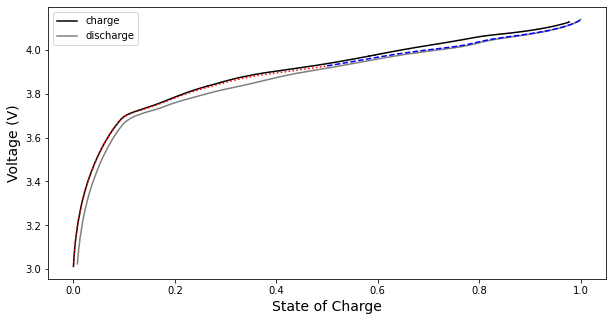

In [33]:
# Here's a visualization of the processing. We use charge curve at 
# low SOC, and discharge curve at high SOC, with a smooth transition between the two.
plt.figure(figsize=(10,5))
plt.plot(chgZ,chgV,color='black',label='charge')
plt.plot(disZ,disV,color='grey',label='discharge')
plt.plot(zChg,vChg,color='red',ls='dotted')
plt.plot(zDis,vDis,color='blue',ls='dashed')
plt.legend()
plt.xlabel('State of Charge',fontsize=14)
plt.ylabel('Voltage (V)',fontsize=14)

In [34]:
SOC = np.arange(0,1,0.005)
rawocv_interpolation = interp1d(np.concatenate([zChg,zDis]), \
                        np.concatenate([vChg,vDis]), \
                        kind='linear',fill_value="extrapolate")
rawocv = rawocv_interpolation(SOC)

Text(0, 0.5, 'Voltage (V)')

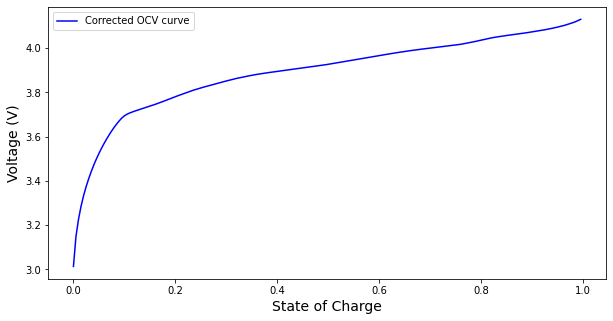

In [35]:
plt.figure(figsize=(10,5))
plt.plot(SOC,rawocv,color='blue',label='Corrected OCV curve')
plt.legend()
plt.xlabel('State of Charge',fontsize=14)
plt.ylabel('Voltage (V)',fontsize=14)